# 변종3

* KS통계량 값을 가중치로 학습시키기 
* 1  컬럼수만큼이 좋을지 
* 2  1이라는 수가 좋을지 
* magan 처럼 boundary 를 주는 방식으로

## > 학습이 잘 안된다.....
## > Hinge loss로 변경하기 (Dloss)
## > boundary seek gan Gloss 사용하기.
## SNGAN https://github.com/isr-wang/SNGAN/blob/master/generator.py

## 일단 기존 방식 Loss 유지하고, 이제는 다른 방식으로 진행해볼까 함 (Experince Memory 활용)
* 1. gloss, dloss 가장 낮은 기점을 계속 낮게 만드는 방식으로 진행
* 2. 그림이 엉망으로 나올 때는 가장 좋았던 경험의 데이터로 학습시키기.
* 3. https://github.com/utkd/gans/blob/master/cifar10cgan.ipynb Experience MeMory 활용해보기 맞게 한지는 모르겠음

In [24]:

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
from scipy.stats import skew
from scipy.stats import kurtosis
slim = tf.contrib.slim
from sklearn.preprocessing import MinMaxScaler
from tensorflow.contrib.distributions import percentile as tf_percent



In [25]:
import os
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


In [26]:
data = pd.read_csv("./credit44_sc.csv" )

In [27]:
fac_var = []
num_var = []
for i in list(data) : 
    if data[i].nunique() < 15 : 
        print("factor variable : {}, count : {} ".format(i, data[i].nunique()))
        fac_var.append(i)
        if data[i].nunique() == 2 :
            print("binary" , i)
    else : 
        print("연속형 variable : {} , count : {} ".format(i, data[i].nunique()))
        num_var.append(i)
        
data = data.loc[:,fac_var + num_var]

col = list(data)


scaler = MinMaxScaler(feature_range= (-1,1))
data = scaler.fit_transform(data)


연속형 variable : SCORE_ORG , count : 395 
연속형 variable : SCORE_NK0200_000 , count : 445 
연속형 variable : SCORE_RK0400_700 , count : 294 
factor variable : CNT_CONTACT_POS, count : 8 
factor variable : CNT_ENG, count : 7 
factor variable : DAYS_CONTACT_POS, count : 11 
factor variable : DAYS_CALL_PAYMENT, count : 11 
factor variable : EWS_C_N_P27000100, count : 14 
연속형 variable : EWS_A_K_D1M232000_OPR , count : 2384 
factor variable : EWS_C_N_P42000200, count : 14 
연속형 variable : EWS_C_N_P32003000 , count : 31 
연속형 variable : AGE , count : 54 
연속형 variable : CNT_Contact , count : 29 
연속형 variable : EWS_A_K_D1M23200C_OPR , count : 2384 
연속형 variable : EWS_C_K_D10310000_OPR , count : 52 
연속형 variable : EWS_A_K_D90232200_OPR , count : 2490 
연속형 variable : D_N_CA0000603 , count : 4894 
연속형 variable : EWS_C_N_P32002600 , count : 22 
연속형 variable : EWS_D_N_P43004000 , count : 399 
factor variable : C_N_PS0001777, count : 11 
factor variable : A_K_D10220000_OPR, count : 9 
연속형 variable : SCORE_RK

/home/gpuadmin/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [28]:
X_dim = 45  
z_dim = 64
h_dim = 128
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=[None, X_dim], name="X")
z = tf.placeholder(tf.float32, shape=[None, z_dim], name="z")
m = tf.placeholder(tf.float32 , name  = "KS")


def sample_z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

device = ['/cpu:0' , '/cpu:0']

def G( Z = None , reuse = tf.AUTO_REUSE) : 
    with tf.device(device[1]) :
        with tf.variable_scope("Generator" , reuse = reuse) as scope: 
            G_W1 = tf.get_variable("GW1",[z_dim, h_dim], dtype=tf.float32)
            G_b1 = tf.get_variable("GB1",[h_dim],dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            G_W2 = tf.get_variable("GW2" ,[h_dim, h_dim], dtype=tf.float32)
            G_b2 = tf.get_variable("GB2",[h_dim], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            G_W3 = tf.get_variable("GW3" ,[h_dim, X_dim], dtype=tf.float32)
            G_b3 = tf.get_variable("GB3",[X_dim], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            
            G_h1 = tf.layers.dropout(tf.matmul(Z, G_W1) + G_b1)
            G_h1 = tf.layers.batch_normalization(G_h1)
            G_h1 = tf.nn.leaky_relu(G_h1)
            G_h2 = tf.layers.dropout(tf.matmul(G_h1, G_W2) + G_b2)
            G_h2 = tf.layers.batch_normalization(G_h2)
            G_h2 = tf.nn.leaky_relu(G_h2)
            
            G_log_prob = tf.matmul(G_h2, G_W3) # + G_b2 Bias는 일단 제외 
            ## tanh 가 sigmoid 보다 gradient 소실에 더 강하다.        
        return G_log_prob


##  그래프를 그리고 파라미터 튜닝 통해서,  데이터 생성

In [29]:
chkpt_fname = tf.train.latest_checkpoint("./")

x_generated = G(z)

In [35]:
init = tf.global_variables_initializer()
sess = tf.Session()
saver = tf.train.Saver()
sess.run(init)
saver.restore(sess, chkpt_fname)
z_test_value = sample_z(m=5000 , n=z_dim)
x_gen_val = sess.run(x_generated, feed_dict={z : z_test_value})

total = scaler.inverse_transform(x_gen_val)
g_plot = pd.DataFrame(total , columns = col )
g_plot[fac_var] = g_plot[fac_var].round(0)


INFO:tensorflow:Restoring parameters from ./V0_SN_MODEL_V3


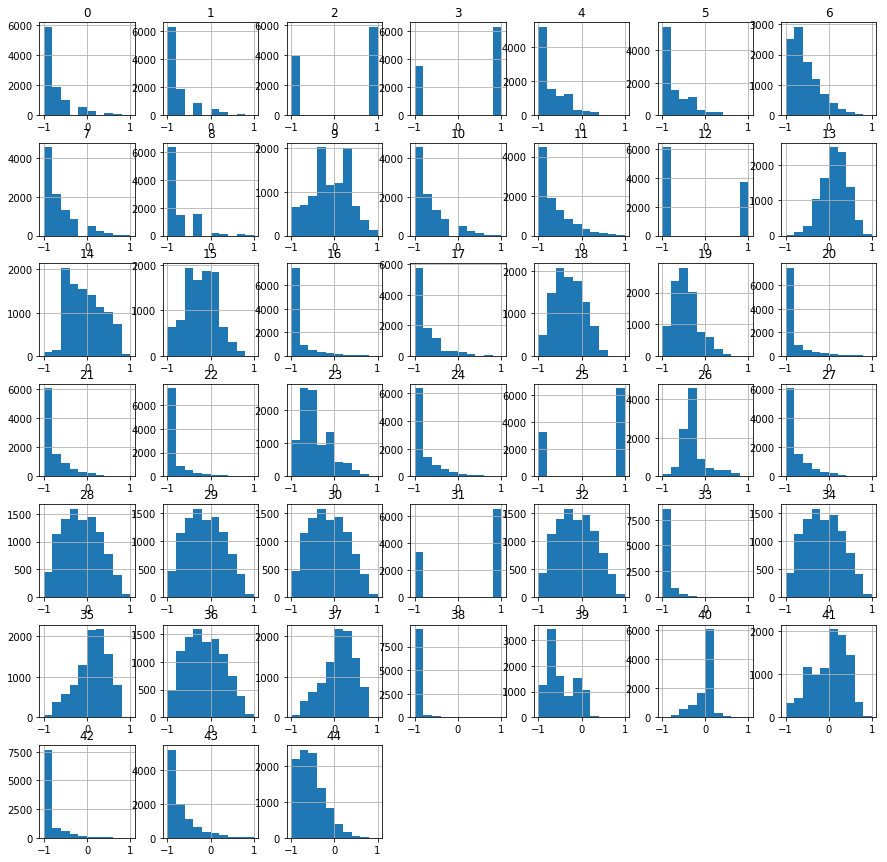

In [38]:
"""
Real
"""

pd.DataFrame(data).hist(figsize =(15,15))
plt.show()

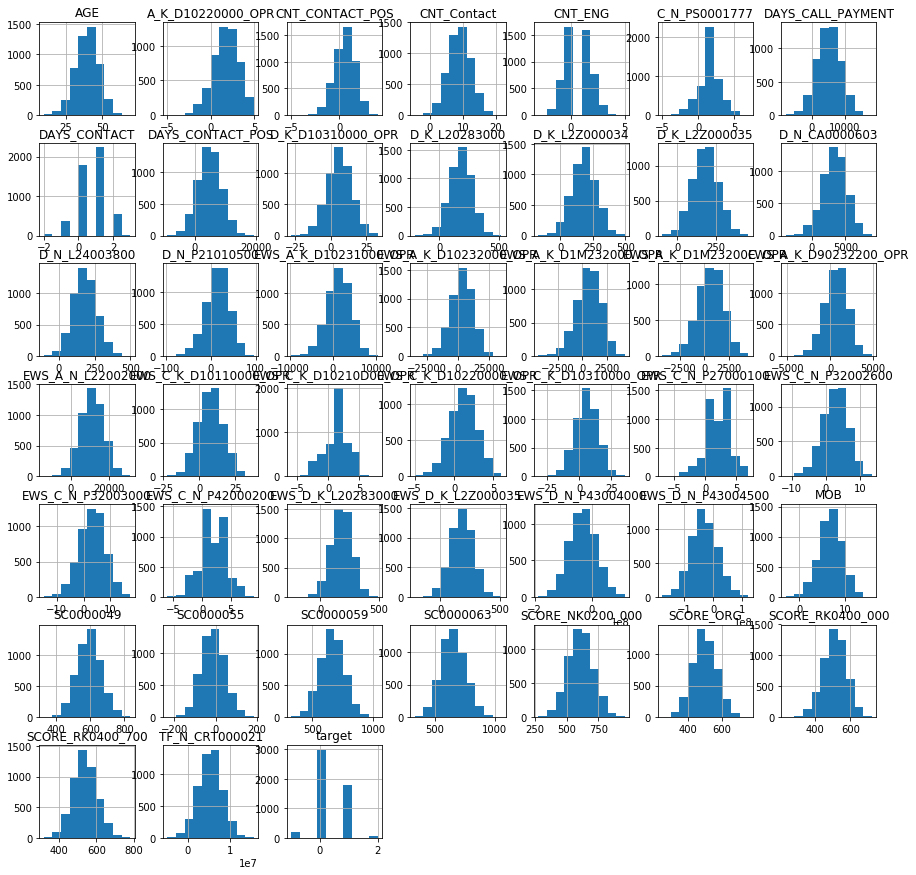

In [34]:
g_plot.hist(figsize = (15,15))
plt.show()